In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math 

from numba import jit
from numba import cuda

import time

In [294]:
def flat(Momentum_grid, Space_grid):
    Momentum_num = np.prod(Momentum_grid.shape[-1])
    Space_num = np.prod(Space_grid.shape[-1])
    
    return Momentum_grid.reshpe([Momentum_num,3]), Space_grid.reshape([Space_num,3]), np.zeros(Space_num)

@cuda.jit('void(float64[:], float64[:,:], float64[:,:], float64[:], float64[:], int32, int32)')
def Fourier_Transform(values, coor, momentum, patternCos, patternSin, coor_num, momen_num):    
    # c is the coordinate index
    # m is the momentum index
    c = cuda.grid(1)
    if c < momen_num :
        patternCos[c] = 0
        patternSin[c] = 0
            
        for m in range(coor_num):
            ## Initialize the variables
            holder = 0
            for l in range(3):
                holder += coor[m, l] * momentum[c , l]
                
            patternCos[c] +=  values[m]* math.cos(holder)
            patternSin[c] +=  values[m]* math.sin(holder)
            
@cuda.jit('void(float64[:], float64[:], float64[:], float64[:], int32)')
def Target_and_Difference(patternCos, patternSin, measurement, difference, momen_num):
    c = cuda.grid(1)
    
    ## Initialize the target
    if c < momen_num:
        difference[c] = (patternCos[c]*patternCos[c] + patternSin[c]*patternSin[c] - measurement[c])/512.
        
@cuda.jit('void(float64[:],float64[:],float64[:],float64[:,:],float64[:,:], float64[:], int32,int32)')
def Gradient(difference, patternCos, patternSin, coor, momentum, gradient, coor_num, momen_num):
    # c is the coordinate index
    # m is the momentum index
    c = cuda.grid(1)
    if c < coor_num :
        gradient[c] = 0 # Initialize
        
        for m in range(momen_num):
            holder = 0 # Initialize 
            
            for l in range(3):
                holder += coor[c, l] * momentum[m , l]
                
            gradient[c] += 4*difference[m]* (patternCos[m]*math.cos(holder) + patternSin[m]*math.sin(holder))/512.

# Begin Line Search: Prepare the Variables

In [209]:
# Load coordinate, momentum, sample
ground_truth = np.load('./sample_regular.npy')
#ground_truth = ground_truth*2 + 1

ground_truth_1d = ground_truth.reshape([-1])
coor_num = ground_truth_1d.shape[0]

coordinate_grid_1d = np.load('./coordinate_grid_flat.npy')

momentum = np.load('./momentum_grid.npy')
momen_num = np.prod(momentum.shape[:-1])
momentum_grid_1d = momentum.reshape([momen_num , 3])

# Create the history array to holds intermidiate results
iter_num = 500
history_guess = np.zeros((iter_num, ground_truth_1d.shape[0]))
history_loss = np.zeros(iter_num)

# Create patternCos, patternSin, gradient, difference, target
patternCos = np.zeros(momen_num)
patternSin = np.zeros_like(patternCos)
gradient = np.zeros(coor_num)
difference = np.zeros(momen_num)

## Move all these variables to the GPU
cuda_ground_truth = cuda.to_device(ground_truth_1d)
cuda_coordiante = cuda.to_device(coordinate_grid_1d)
cuda_momentum = cuda.to_device(momentum_grid_1d)

cuda_history_guess = cuda.to_device(history_guess)
cuda_history_loss = cuda.to_device(history_loss)
cuda_patternCos = cuda.to_device(patternCos)
cuda_patternSin = cuda.to_device(patternSin)
cuda_gradient = cuda.to_device(gradient)
cuda_difference = cuda.to_device(difference)

# Calculate the measurement

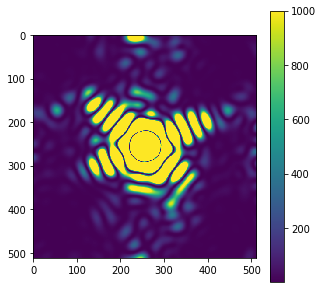

(262144,)


In [296]:
# Calculate the actual diffraction pattern
Fourier_Transform[(momen_num + 511)/512, 512](cuda_ground_truth, cuda_coordiante, 
                  cuda_momentum, cuda_patternCos, cuda_patternSin,
                  coor_num, momen_num)
cuda_patternCos.to_host()
cuda_patternSin.to_host()

result = np.square(patternCos) + np.square(patternSin)

result_2d = np.reshape(result, (512,512))

plt.figure(figsize=(5,5))
plt.imshow(result_2d,vmax=1e3)
plt.colorbar()
plt.show()

# Move the measurement to gpu
measurement = np.copy(result)
print measurement.shape

cuda_measurement = cuda.to_device(measurement)

# Calculate the difference when the initial guess is exact

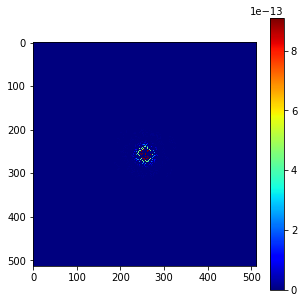

The total difference is 0.000000


In [297]:
loss = 100

## Set up the initial guess
initial_guess = np.copy(ground_truth_1d)
cuda_initial_guess = cuda.to_device(initial_guess)

# Calculate the actual diffraction pattern
Fourier_Transform[(momen_num + 511)/512, 512](cuda_initial_guess,
                                              cuda_coordiante, 
                                              cuda_momentum,
                                              cuda_patternCos,
                                              cuda_patternSin,
                                              coor_num, momen_num)

# Calculate the actual diffraction pattern
Target_and_Difference[(momen_num + 511)/512, 512](cuda_patternCos, 
                                                  cuda_patternSin,
                                                  cuda_measurement,
                                                  cuda_difference,
                                                  momen_num)


cuda_difference.to_host()

result_2d = np.reshape(difference, (512,512))

plt.figure(figsize=(5,5))
plt.imshow(np.abs(result_2d), cmap = 'jet')
plt.colorbar()
plt.show()

print "The total difference is %f"%(np.sum(np.abs(difference)))

# Calculate the gradient when the initial guess is exact.

In [298]:
# Calculate the gradient
Gradient[(momen_num + 511)/512, 512](cuda_difference ,
                                    cuda_patternCos,
                                    cuda_patternSin,
                                    cuda_coordiante, 
                                    cuda_momentum, 
                                    cuda_gradient, 
                                    coor_num, momen_num)

cuda_gradient.to_host()
print "The length of the gradient is %f"%(np.sqrt(np.sum(np.square(gradient))))
print "The maximal value of the gradient is %f"%(np.max(np.abs(gradient)))
print "The mean value of the gradient is %f"%(np.mean(np.abs(gradient)))

The length of the gradient is 0.000000
The maximal value of the gradient is 0.000000
The mean value of the gradient is 0.000000


# Begin line search test once

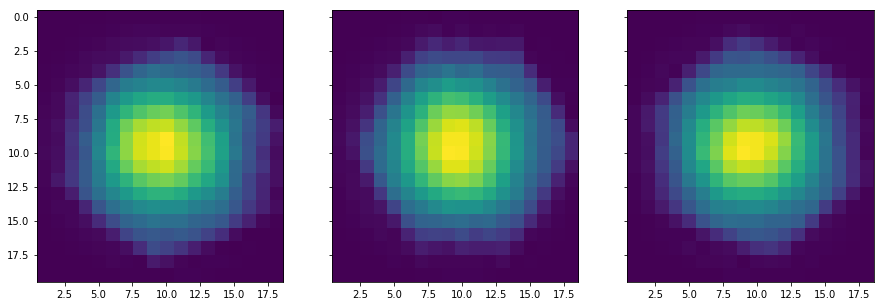

In [315]:
# Setup initial guess
initial_guess = data.reshape(8000)/2 + ground_truth_1d/2
cuda_initial_guess = cuda.to_device(initial_guess)

guess_3d = np.reshape(initial_guess, (20,)*3)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.imshow(np.sum(guess_3d,axis=0))
ax2.imshow(np.sum(guess_3d,axis=1))
ax3.imshow(np.sum(guess_3d,axis=2))

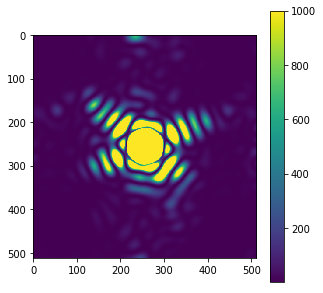

In [316]:
# Calculate the actual diffraction pattern
Fourier_Transform[(momen_num + 511)/512, 512](cuda_initial_guess, cuda_coordiante, 
                  cuda_momentum, cuda_patternCos, cuda_patternSin,
                  coor_num, momen_num)
cuda_patternCos.to_host()
cuda_patternSin.to_host()

result = np.square(patternCos) + np.square(patternSin)

result_2d = np.reshape(result, (512,512))

plt.figure(figsize=(5,5))
plt.imshow(result_2d,vmax=1e3)
plt.colorbar()
plt.show()

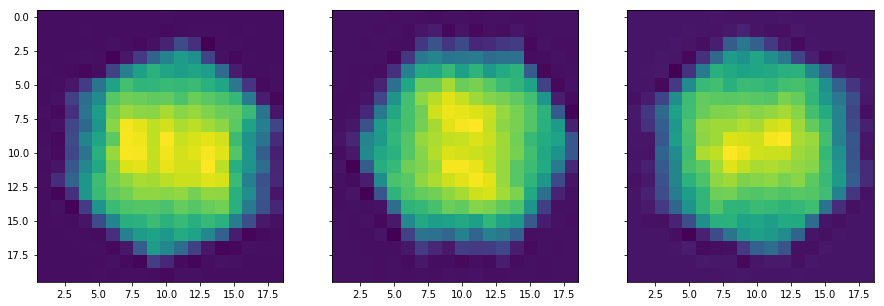

In [311]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.imshow(np.sum(ground_truth,axis=0))
ax2.imshow(np.sum(ground_truth,axis=1))
ax3.imshow(np.sum(ground_truth,axis=2))

# Do line search for a long time

In [317]:

previous_momentum = np.zeros(coor_num)

for iter_num in range(500):
    print " This is the %d iteration"%iter_num
    
    # Define some useful variables
    grad_norm = 0
    loss = 0
    updated_loss = 0
    holder = 0
    
    step_size = 0.1
    decay_rate = 0.1
    
    # Calculate the actual diffraction pattern
    Fourier_Transform[(momen_num + 511)/512, 512](cuda_initial_guess,
                                                  cuda_coordiante, 
                                                  cuda_momentum,
                                                  cuda_patternCos,
                                                  cuda_patternSin,
                                                  coor_num, momen_num)

    # Calculate the actual diffraction pattern
    Target_and_Difference[(momen_num + 511)/512, 512](cuda_patternCos, 
                                                      cuda_patternSin,
                                                      cuda_measurement,
                                                      cuda_difference,
                                                      momen_num)

    Gradient[(momen_num + 511)/512, 512](cuda_difference ,
                                        cuda_patternCos,
                                        cuda_patternSin,
                                        cuda_coordiante, 
                                        cuda_momentum, 
                                        cuda_gradient, 
                                        coor_num, momen_num)

    # move the gradient to cpu
    cuda_gradient.to_host()
    grad_norm = np.sum(np.square(gradient))
    #gradient *= 8000./ np.sqrt(grad_norm)
    
    ## Add previous momentum
    #gradient += 0.5* previous_momentum
    #previous_momentum = gradient

    ## Move back
    cuda_gradient = cuda.to_device(gradient)
    
    print np.max(np.abs(gradient)) , np.min(np.abs(gradient))
    
    cuda_difference.to_host()
    loss = np.sum(np.square(difference))
    cuda_difference = cuda.to_device(difference)
    
    while True:

        time1 = time.time()
        ##############################################################################################
        ## update the guess
        ##############################################################################################
        cuda_initial_guess.to_host()
        updated_guess = initial_guess - step_size*gradient
        #if np.any(updated_guess < 0 ):
        #    step_size = step_size* decay_rate
        #    continue

        cuda_updated_guess = cuda.to_device(updated_guess)

        ##############################################################################################
        ## Calculate the fourier transition
        ##############################################################################################
        Fourier_Transform[(momen_num + 511)/512, 512](cuda_updated_guess,
                                                  cuda_coordiante, 
                                                  cuda_momentum,
                                                  cuda_patternCos,
                                                  cuda_patternSin,
                                                  coor_num, momen_num)

        ##############################################################################################
        ## Calculate the loss function and the difference
        ##############################################################################################
        Target_and_Difference[(momen_num + 511)/512, 512](cuda_patternCos, 
                                                          cuda_patternSin,
                                                          cuda_measurement,
                                                          cuda_difference,
                                                          momen_num)

        ## Check the condition
        cuda_difference.to_host()
        updated_loss = np.sum(np.square(difference))
        cuda_difference = cuda.to_device(difference)
        
        ## If the condition is satified, then return. Otherwise update the step size
        if updated_loss <= loss - step_size/2*grad_norm :

            # update history and guess
            history_loss[iter_num] = updated_loss
            
            cuda_updated_guess.to_host()
            initial_guess = updated_guess
            cuda_initial_guess = cuda.to_device(initial_guess)
            
            history_guess[iter_num] = initial_guess
            
            print loss, updated_loss , loss > updated_loss
            
            break

        step_size = step_size* decay_rate


 This is the 0 iteration
5651428.82828 11020.1521095
232146340.294 202980825.258 True
 This is the 1 iteration
5007219.9634 3064.01805705
202980825.258 180298424.096 True
 This is the 2 iteration
4482522.0781 269.087517554
180298424.096 77304429.3066 True
 This is the 3 iteration
1417694.83895 106.49448707
77304429.3066 68982728.4688 True
 This is the 4 iteration
1239117.8201 27935.7864938
68982728.4688 62934523.5984 True
 This is the 5 iteration
1092789.25268 432.449170673
62934523.5984 58387197.5111 True
 This is the 6 iteration
972773.21274 19859.6640491
58387197.5111 54843852.6129 True
 This is the 7 iteration
925727.028997 3710.23395527
54843852.6129 39089174.1755 True
 This is the 8 iteration
1499396.46166 291.565381356
39089174.1755 37246966.5281 True
 This is the 9 iteration
1336710.46903 35.8152207787
37246966.5281 35894738.6827 True
 This is the 10 iteration
1205935.87378 2.88608894866
35894738.6827 34851379.4465 True
 This is the 11 iteration
1099940.69085 19.0834403349
3485

KeyboardInterrupt: 

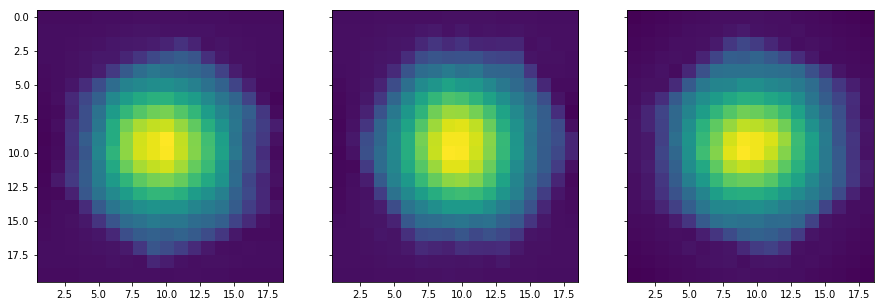

In [318]:
cuda_updated_guess.to_host()

guess_3d = np.reshape(updated_guess, (20,)*3)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.imshow(np.sum(guess_3d,axis=0))
ax2.imshow(np.sum(guess_3d,axis=1))
ax3.imshow(np.sum(guess_3d,axis=2))



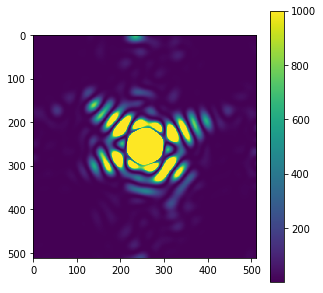

In [319]:
cuda_patternCos.to_host()
cuda_patternSin.to_host()

result = np.square(patternCos) + np.square(patternSin)

result_2d = np.reshape(result, (512,512))

plt.figure(figsize=(5,5))
plt.imshow(result_2d,vmax=1e3)
plt.colorbar()
plt.show()

In [124]:
data = np.zeros((20,)*3)

In [283]:
for l in range(20):
    for m in range(20):
        for n in range(20):
            data[l,m,n] = np.exp(-((l- 9.5)**2 + (m-9.5)**2 + (n-9.5)**2)/20.)

In [284]:
data = data/np.sum(data)*np.sqrt(3509899.23623)

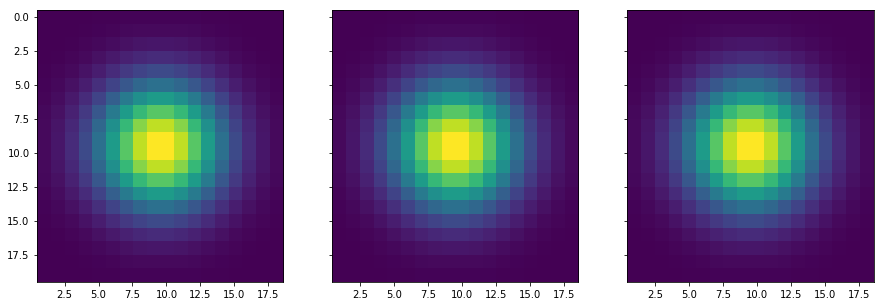

In [285]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.imshow(np.sum(data,axis=0))
ax2.imshow(np.sum(data,axis=1))
ax3.imshow(np.sum(data,axis=2))

In [282]:
np.sum(ground_truth)

1873.4725074648441